In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav

import tol_colors
from scipy.interpolate import interp1d
from scipy.signal import convolve


In [108]:
# before this, will need to save variables tg1t, z1t, ne1t, pg1t, q, nq, qnorm, outintt, nmu to save file... or access some other way
filename='/Users/coletamburri/Desktop/radyn_15_8_5e9.sav'
#filename_dkist = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/dkist_obs_file.npz'

# change based on desired line and fwhm of observations

kr=20 #Ca II H - 20 is Ca II 8542
timesinit = np.linspace(0,200,4) #times to print out in plots, in seconds
times2 = [250,430,500] #decay phase times to print out in plots - will be concatenated to timesinit array
lamb0=854.2 # change this and the instances below to wavelength of spectral line in nm as desired (as needed)
c=2.99e5
mu=.5 #viewing angle cos(theta) - choose between 0.05, 0.23, 0.5, 0.77, 0.95
muind = 2 # index corresponding to the value above; 0=0.05, 1=0.23, 2=0.5, 3=0.77, 4=0.95
fwhm=.05 #dkist FWHM
ntw=45 # DKIST NTW


In [110]:
read = readsav(filename)

In [112]:
#dkist_file = np.load(filename_dkist)
#dkist_wl = dkist_file['arr_2']

In [114]:
read

{'tg1t': array([[3.10032667e+06, 3.10032667e+06, 3.08511760e+06, ...,
         7.27928764e+03, 7.64734200e+03, 8.01730673e+03],
        [3.10042907e+06, 3.10042907e+06, 3.08522619e+06, ...,
         7.27929360e+03, 7.64734367e+03, 8.01730685e+03],
        [3.13024313e+06, 3.13024313e+06, 3.11395163e+06, ...,
         7.27246798e+03, 7.64557737e+03, 8.01733403e+03],
        ...,
        [7.49386724e+06, 7.49386724e+06, 7.49383730e+06, ...,
         7.26937510e+03, 7.64481982e+03, 8.01664945e+03],
        [7.48576400e+06, 7.48576401e+06, 7.48573103e+06, ...,
         7.26934617e+03, 7.64481157e+03, 8.01664869e+03],
        [7.47774285e+06, 7.47774285e+06, 7.47770531e+06, ...,
         7.26932339e+03, 7.64480487e+03, 8.01664794e+03]], dtype='>f8'),
 'z1t': array([[ 1.10622306e+09,  1.08562146e+09,  1.06501986e+09, ...,
         -5.20113721e+06, -5.72119705e+06, -6.11148987e+06],
        [ 1.10622306e+09,  1.08562299e+09,  1.06502293e+09, ...,
         -5.20114185e+06, -5.72119703e+06, -6.

In [116]:
np.shape(read['tg1t'])

(615, 191)

In [118]:
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu2

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr
#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range,ntw,gaussian_psf):
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    dw=new_dispersion_range[1]-new_dispersion_range[0]
    dw=dw
    tw=(np.arange(ntw)-ntw//2)*dw
    
    for i in range(1):

    	psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    	yconv = convolve(yatlas, psf, mode='same', method='fft')
        
    return yconv


def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.AA)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

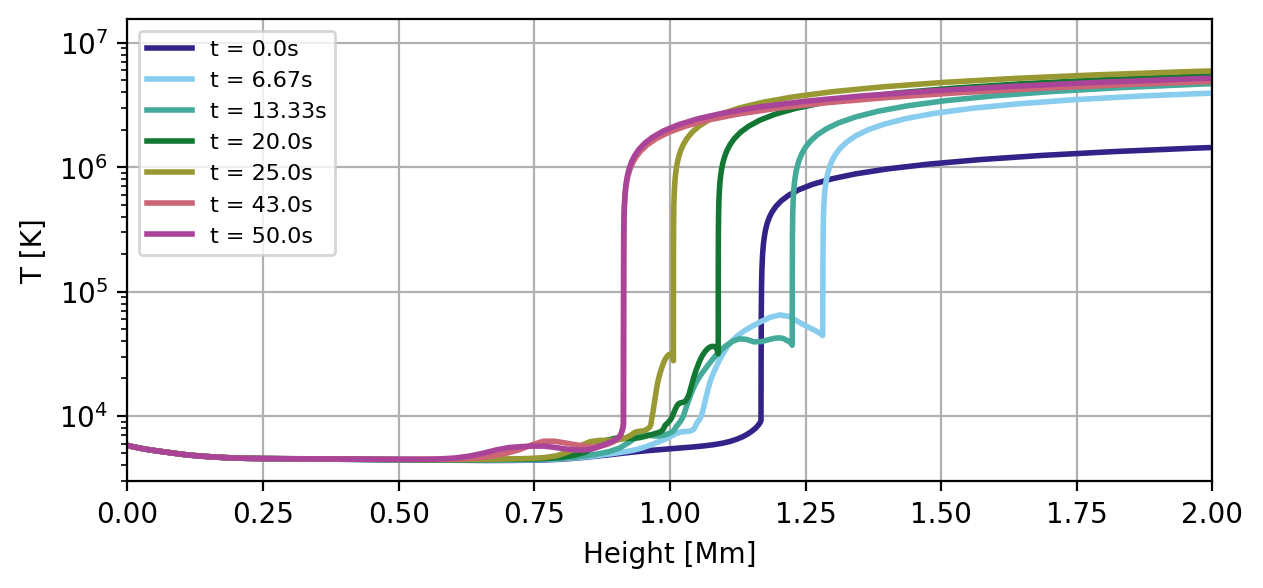

In [120]:
timesinit = np.linspace(0,200,4)
times2 = [250,430,500]

ncol2 = len(timesinit)+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))

cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499']

fig,ax=plt.subplots(dpi=200,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read['z1t'][int(timesinit[i]),:]/1e8,(read['tg1t'][int(timesinit[i]),:]),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

for i in range(len(times2)):
    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['tg1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
ax.legend(fontsize=8)
ax.set_ylabel('T [K]')
ax.set_xlabel('Height [Mm]')
ax.set_xlim([0,2])
plt.yscale('log')

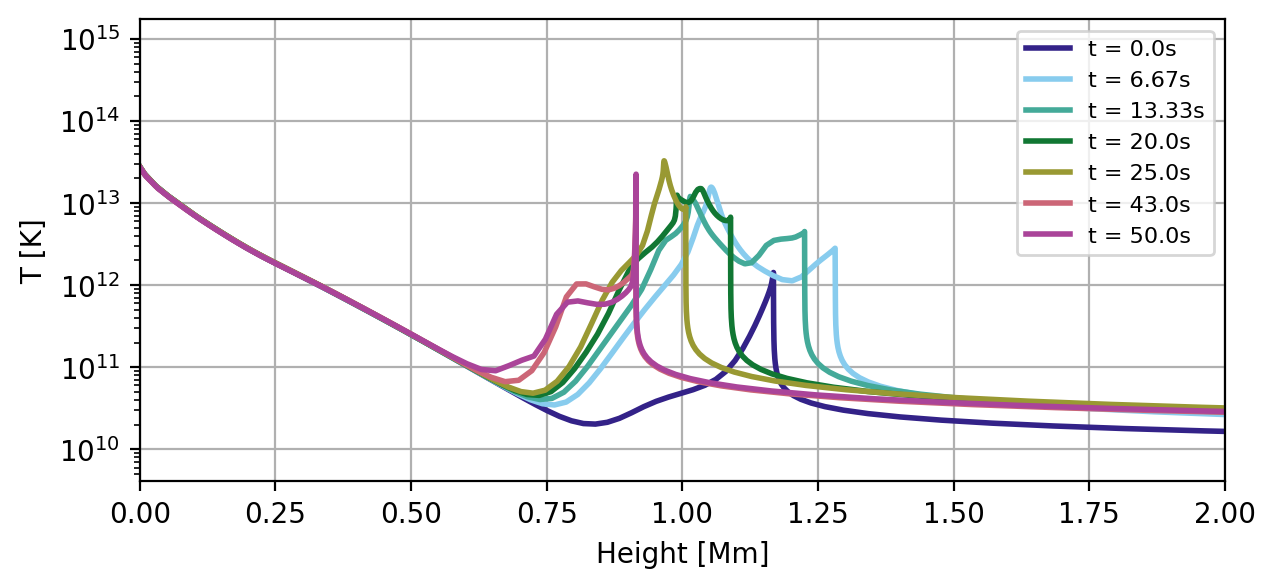

In [122]:
timesinit = np.linspace(0,200,4)
times2 = [250,430,500]

ncol2 = len(timesinit)+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))

cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499']

fig,ax=plt.subplots(dpi=200,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read['z1t'][int(timesinit[i]),:]/1e8,(read['ne1t'][int(timesinit[i]),:]),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

for i in range(len(times2)):
    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['ne1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
ax.legend(fontsize=8)
ax.set_ylabel('T [K]')
ax.set_xlabel('Height [Mm]')
ax.set_xlim([0,2])
plt.yscale('log')

In [123]:
def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

In [126]:
# I think 1.9e11 is the conversion...

In [128]:
q = read['q']
nq = read['nq']
qnorm = read['qnorm']
outintt = read['outintt']
nmu = read['nmu']
#q[0:nq[kr]-1,kr]*qnorm,outintt[1:nq[kr],nmu-1,kr,*]

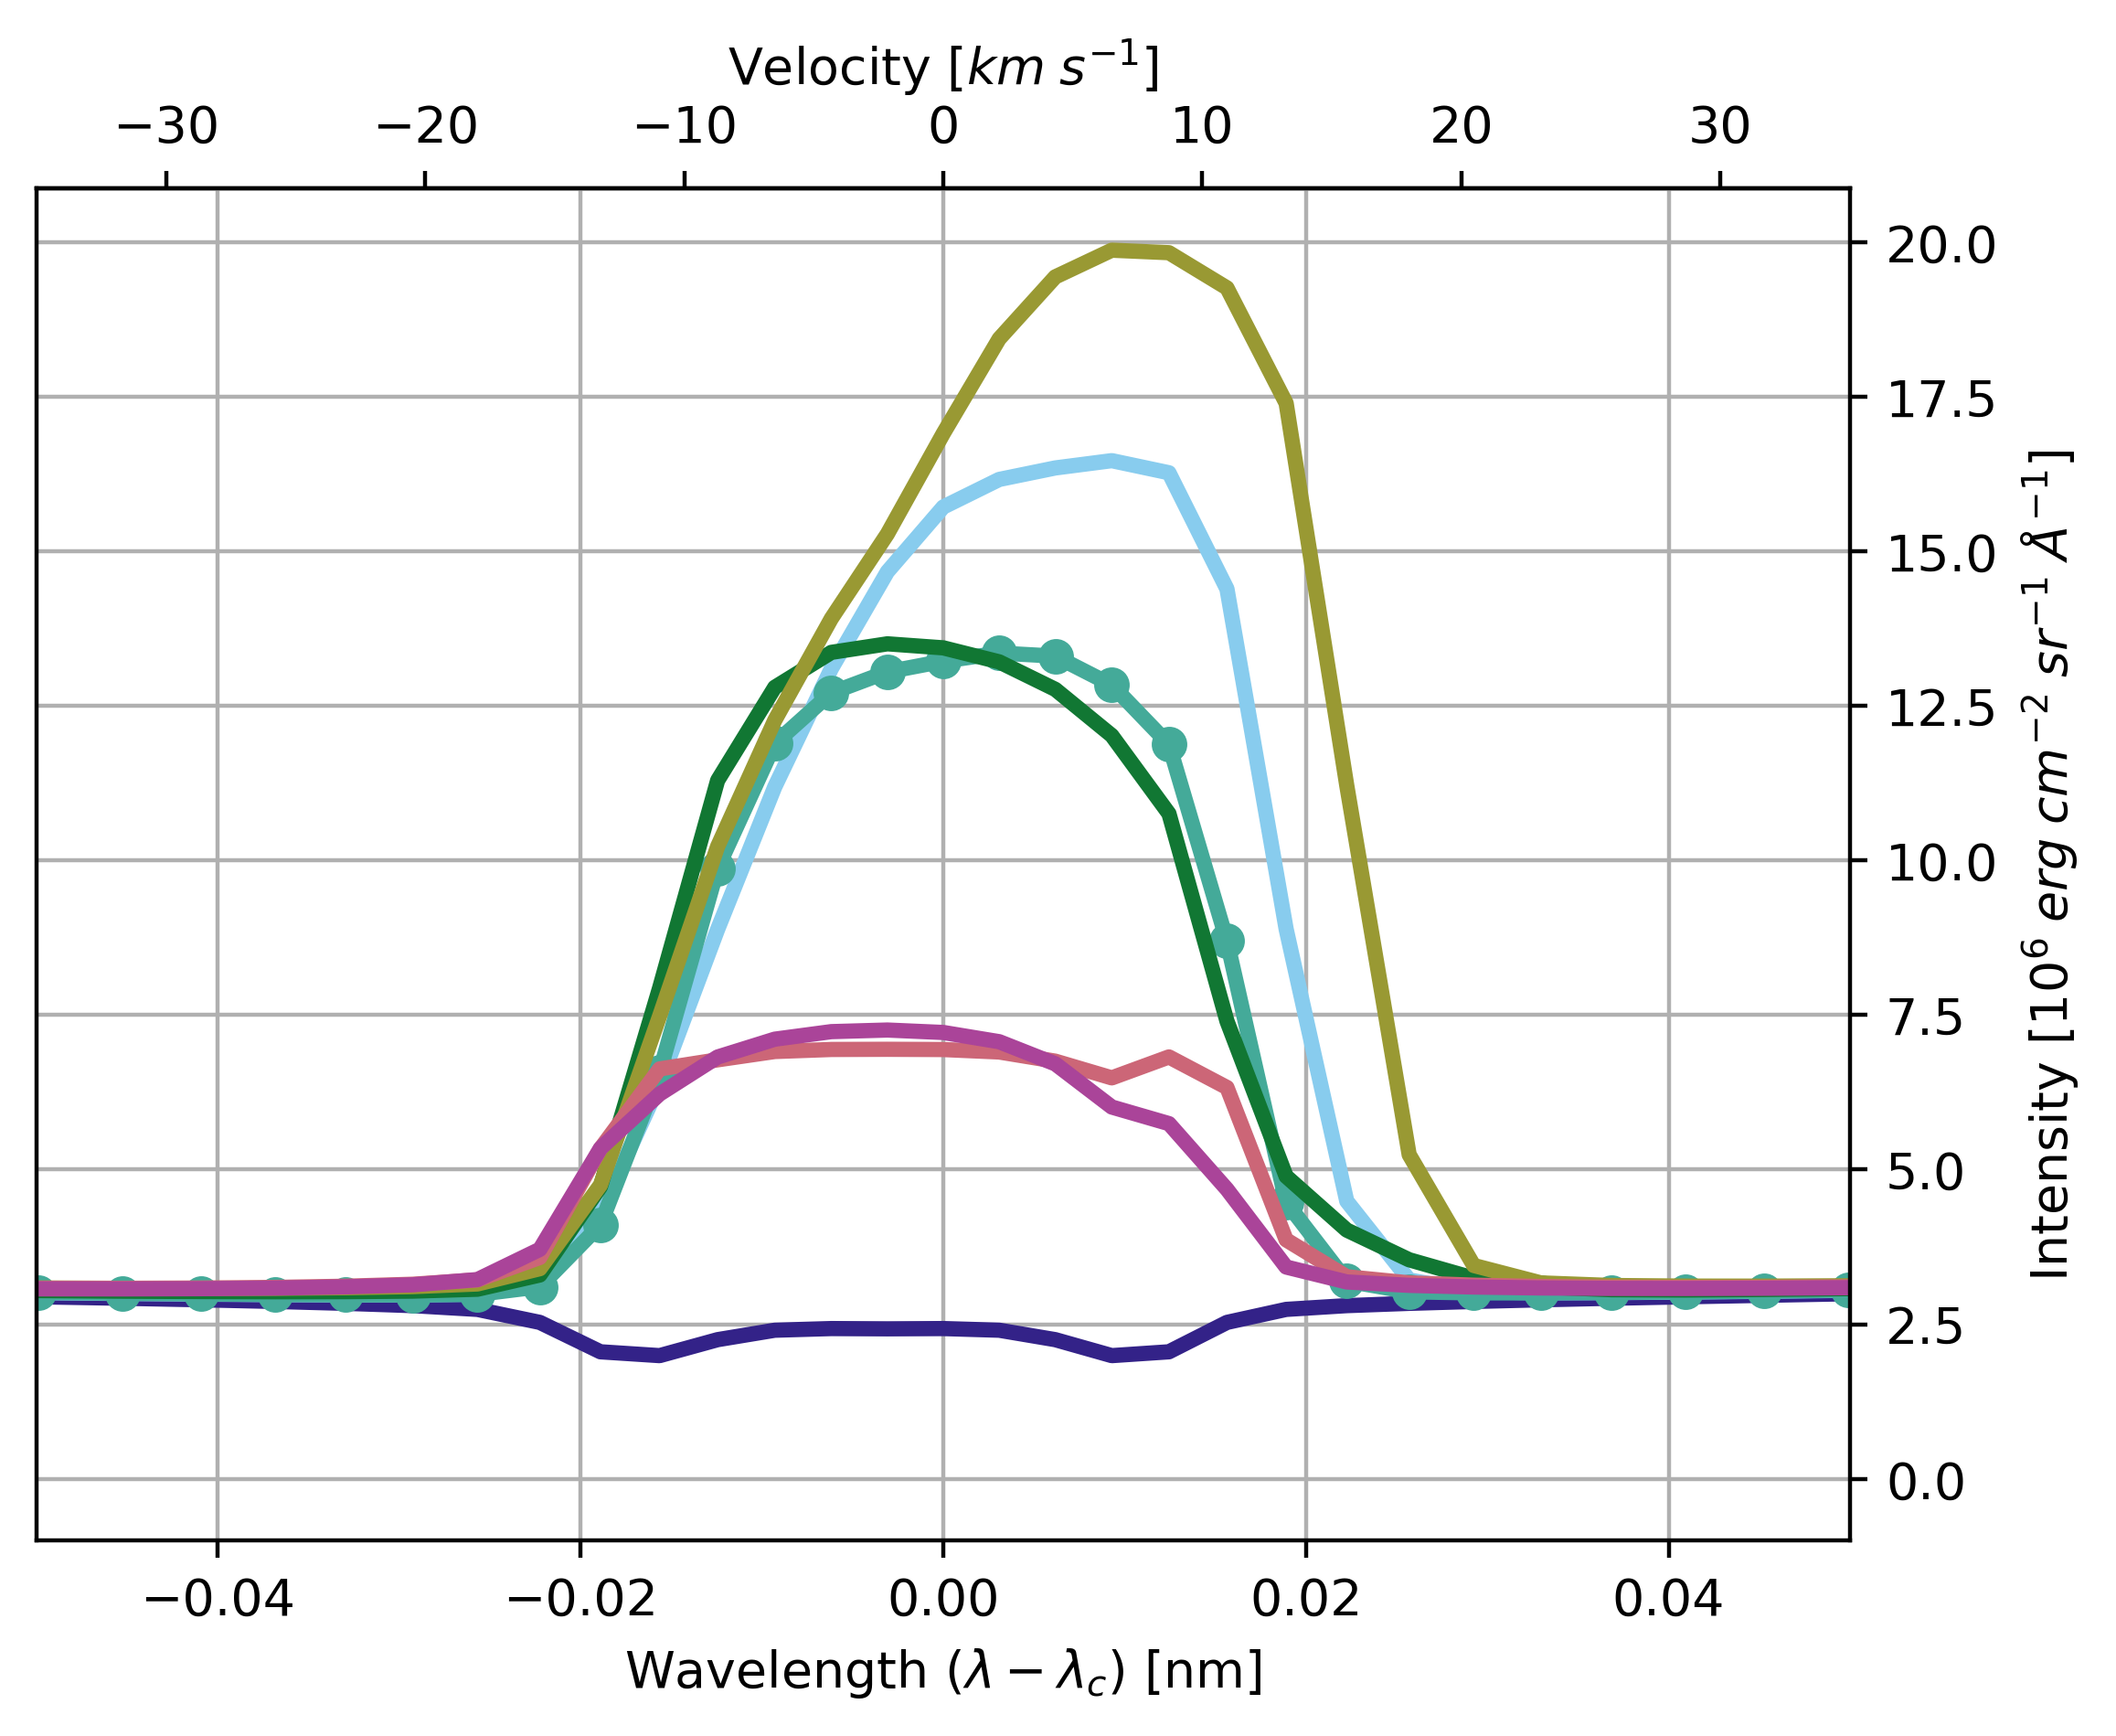

In [130]:


cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499']


wavelengths = (doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm))

fig,ax=plt.subplots(dpi=400)
for i in range(len(timesinit)):
    if i==2:
        ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,marker='o',color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
    else:
        ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
       
    ax.set_xlim([.05,-.05])
for i in range(len(times2)):
    ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(times2[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=3)
plt.gca().invert_xaxis()
#ax.legend()
#ax.axvline(0,c='black')
ax.grid()
ax.set_ylabel(r'Intensity [$10^6\;erg\;cm^{-2}\;sr^{-1}\;\AA^{-1}$]')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.set_xlabel(r'Wavelength ($\lambda - \lambda_c$) [nm]')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()